In [1]:
from dotenv import load_dotenv

In [57]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from groq import Groq
import operator
from langchain_groq import ChatGroq
import json
from langchain_openai import ChatOpenAI



In [31]:
load_dotenv()

True

In [32]:
tool = TavilySearchResults(max_results=4)

In [33]:
tool("Who is the cureent president of the United States?")

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': 'Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\nPresident of the United States\n\nThe president of the United States is the:\n\n   U.S. head of state\n   Leader of the executive branch\n   Commander in chief of the armed forces\n\n### Current president\n\nThe 47th and current president of the United States is Donald John Trump.He was sworn into office on January 20, 2025. [...] The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n\n### Current vice president\n\nThe 50th and cur

In [34]:
tool.name

'tavily_search_results_json'

In [70]:
class AgentState(TypedDict):
    messages:Annotated[list[AnyMessage], operator.add]

In [142]:
class Agent:

    def __init__(self, state:AgentState, tools, system_msg="", model_name="llama-3.1-8b-instant"):
        self.system_msg = system_msg
        self.graph = StateGraph(state)
        self.model = ChatGroq(model=model_name)
        self.model_name = model_name
        self.graph.add_node("llm", self.call_llm)
        self.graph.add_node("action", self.action)
        self.graph.set_entry_point("llm")
        self.graph.add_edge("action", "llm")
        self.graph.add_conditional_edges(
            "llm",
            self.continue_action,
            {True:"action", False: END}
        )
        self.graph = self.graph.compile()
        
        self.tools = {t.name: t for t in tools}
        #self.model = self.model.bind_tools(self.tools)
        self.model = self.model.bind_tools(list(self.tools.values()))

    def call_llm(self, state:AgentState)->AgentState:
        messages = state['messages']
        if self.system_msg:
            messages = [SystemMessage(content= self.system_msg)] + messages 
        res = self.model.invoke(messages)
        return {'messages':[res]}
    def continue_action(self, state:AgentState):

        last_res = state['messages'][-1]
        return len (last_res.tool_calls) > 0
    def action(self,state:AgentState)->AgentState:
        last_res = state['messages'][-1]
        tool_result = []
        print(last_res.tool_calls)

        for tool_call in last_res.tool_calls:
            print(f"Calling tool {tool_call['name']} with args {tool_call['args']}")
            if tool_call['name'] in self.tools:
                res = self.tools[tool_call['name']].invoke(tool_call['args']['query'])
                #content=json.dumps(res, ensure_ascii=False)  # or str(res)
                print(f"Tool result: {str(res)}")
                tool_result.append(ToolMessage(content=str(res), name=tool_call['name'], tool_call_id = tool_call['id']))
            else:
                print("Tool not foun")
                tool_result.append(ToolMessage(content=f"Tool {tool_call.name} not found", tool_call=tool_call))
        return {'messages': tool_result}


In [143]:
tool.name

'tavily_search_results_json'

In [144]:
tools = [tool]


In [145]:
tools[0].name

'tavily_search_results_json'

In [146]:
agent = Agent(AgentState, tools, system_msg="You are a helpful AI assistant.", model_name="llama-3.1-8b-instant")

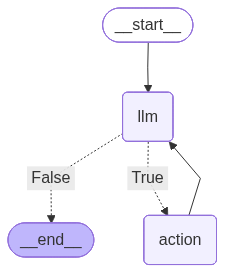

In [147]:
display(Image(agent.graph.get_graph().draw_mermaid_png()))

In [148]:
messages = [HumanMessage(content="What is the current weather in sf?")]


In [149]:
result = agent.graph.invoke({'messages': messages})

[{'name': 'tavily_search_results_json', 'args': {'query': 'sf current weather'}, 'id': 'nv5bn8q5y', 'type': 'tool_call'}]
Calling tool tavily_search_results_json with args {'query': 'sf current weather'}
Tool result: [{'title': 'San Francisco Bay Area, CA - National Weather Service', 'url': 'https://www.weather.gov/mtr/', 'content': '+ Local\n  + Drought\n  + National\n Local Programs\n\n  + Additional Information\n  + Weather Ready Nation\n  + Local SKYWARN\n  + Storm Summary Archive\n  + Post Wildfire Debris Flow\n  + Partial County Alerting for Sonoma County\n\nClick a location below for detailed forecast.\n\nLast Map Update: Mon, Oct 13, 2025 at 1:16:37 pm PDT\n\nWatches, Warnings & Advisories\n\nZoom Out\n\nWinter Storm Warning\n\nGale Warning\n\nWinter Weather Advisory\n\nSmall Craft Advisory\n\nFlood Watch\n\nMarine Weather Statement [...] In addition to the rain, isolated thunderstorms are possible Monday - Tuesday. The greatest hazard is lightning strikes and heavy rain, altho

In [150]:
result['messages'][-1].content

'The current weather in San Francisco is rainy with a high of 63F and a low of 51F. There is a chance of thunderstorms across the coastal waters and the bays on Monday and Tuesday, with hazards including lightning, heavy rain, small hail, and waterspouts.'

In [154]:
messages = [HumanMessage(content="What is the current tempareture in sf?")]
result = agent.graph.invoke({'messages': messages})

[{'name': 'tavily_search_results_json', 'args': {'query': 'current temperature in San Francisco'}, 'id': '9f9g4at65', 'type': 'tool_call'}]
Calling tool tavily_search_results_json with args {'query': 'current temperature in San Francisco'}
Tool result: [{'title': 'October 2025 Weather History in San Francisco California, United ...', 'url': 'https://weatherspark.com/h/m/557/2025/10/Historical-Weather-in-October-2025-in-San-Francisco-California-United-States', 'content': 'History:JFMAMJJASOctND2024202320222021  Hourly Temperature in October 2025 in San Francisco18152229112233445566778899101011111212131312 AM12 AM3 AM3 AM6 AM6 AM9 AM9 AM12 PM12 PM3 PM3 PM6 PM6 PM9 PM9 PM12 AM12 AMSepNovNowNowcoolcomfortable  frigid   15°F   freezing   32°F   very cold   45°F   cold   55°F   cool   65°F   comfortable   75°F   warm   85°F   hot   95°F   sweltering  The hourly reported temperature, color coded into bands. The shaded overlays indicate night and civil twilight.  © [...] Francisco1815222911223

In [155]:
result['messages'][-1].content

'The current temperature in San Francisco is around 61.0°F (15.6°C).'